pygame 2.5.2 (SDL 2.28.3, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
Iteration 0, Learning Score: 50.00%
Iteration 1, Learning Score: 81.25%
Iteration 2, Learning Score: 75.00%
Iteration 3, Learning Score: 81.25%
Iteration 4, Learning Score: 93.75%
Iteration 5, Learning Score: 93.75%
Iteration 6, Learning Score: 93.75%


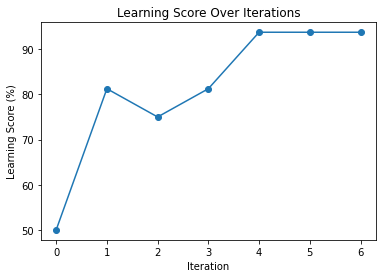

Current State: (0, 0), Action: 0, Reward: -0.01, Score: -0.01
Current State: (1, 0), Action: 1, Reward: -0.01, Score: -0.02
Current State: (1, 0), Action: 0, Reward: -0.01, Score: -0.03
Current State: (2, 0), Action: 1, Reward: -0.01, Score: -0.04
Current State: (2, 0), Action: 1, Reward: -0.01, Score: -0.05
Current State: (2, 0), Action: 3, Reward: -0.01, Score: -0.060000000000000005
Current State: (2, 1), Action: 0, Reward: -0.01, Score: -0.07
Current State: (3, 1), Action: 0, Reward: -0.01, Score: -0.08
Current State: (3, 1), Action: 0, Reward: -0.01, Score: -0.09
Current State: (3, 1), Action: 3, Reward: -0.01, Score: -0.09999999999999999
Current State: (3, 2), Action: 3, Reward: -0.01, Score: -0.10999999999999999
Current State: (3, 3), Action: 0, Reward: -0.01, Score: -0.11999999999999998
Mouse reached the cheese!
Final Score: -0.11999999999999998


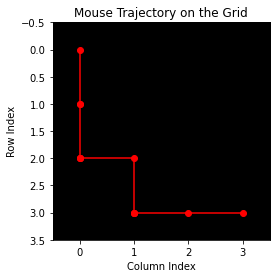

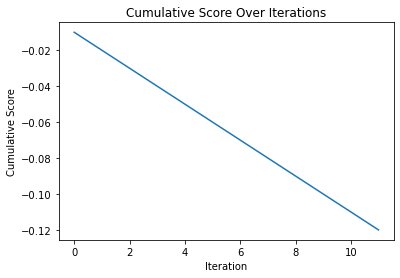

SystemExit: 

/Users/aja/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:

#Install pygame to execute the game
import sys
import random
import pygame
import numpy as np
import matplotlib.pyplot as plt

#Arguments
REWARD = -0.01  # constant reward for non-terminal states
DISCOUNT = 0.99
MAX_ERROR = 10 ** (-3)

# Set the initial environment
BLACK = (0, 0, 0)
WHITE = (200, 200, 200)
GRID_SIZE = 4
NUM_ROW = 4
NUM_COL = 4
WINDOW_HEIGHT = NUM_ROW * 100
WINDOW_WIDTH = NUM_COL * 100
MOUSE_IMAGE_PATH = "mouse.png"
CHEESE_IMAGE_PATH = "cheese.png"
TRAP_IMAGE_PATH = "trap.png"
MARK_IMAGE_PATH ="check_mark.png"

#To meature the performance
cumulative_scores = []


# Set up the initial environment
NUM_ACTIONS = 4
ACTIONS = [(1, 0), (0, -1), (-1, 0), (0, 1)]
U = [[0, 0, 0, 1], [0, 0, 0, -1], [0, 0, 0, 0], [0, 0, 0, 0]]
policy = [[random.randint(0, 3) for j in range(NUM_COL)] for i in range(NUM_ROW)]
trap_positions = [(2, 2), (0, 3), (3, 0),]   # Trap states
cheese_pos = [3, 3]

# Define the reward values
REWARD = {
    'cheese': 10,     # Reward for reaching the cheese
    'trap': -5,       # Penalty for hitting traps
    'default': -0.01  # Default constant reward for non-terminal states
}

#Game definitions
class Game:
    def __init__(self, optimal_policy):
        self.mouse_pos = [0, 0]
        self.previous_mouse_pos = None
        self.score = 0
        self.optimal_policy = optimal_policy
        self.mouse_trajectory = []  # Initialize mouse_trajectory attribute
        self.total_score = 0
        self.total_steps = 0

    def move_mouse(self, action):
        self.previous_mouse_pos = self.mouse_pos.copy()
        self.mouse_trajectory.append(self.mouse_pos.copy())  # Append current position to mouse_trajectory
        # if np.array_equal(action, 0) and self.mouse_pos[0] > 0:
        #     self.mouse_pos[0] -= 1
        if np.array_equal(action, 0) and self.mouse_pos[0] < GRID_SIZE - 1:
            self.mouse_pos[0] += 1
        elif np.array_equal(action, 1) and self.mouse_pos[1] > 0:
            self.mouse_pos[1] -= 1
        elif np.array_equal(action, 2) and self.mouse_pos[0] > 0:
            self.mouse_pos[0] -= 1
        elif np.array_equal(action, 3) and self.mouse_pos[1] < GRID_SIZE - 1:
            self.mouse_pos[1] += 1

    def check_collision(self):
        if tuple(self.mouse_pos) in trap_positions:
            self.score += REWARD['trap']
            self.reset_mouse([0,0])
            print("Inside check_collision: Mouse hit a trap at", self.mouse_pos)
            return REWARD['trap']
        elif tuple(self.mouse_pos) == cheese_pos:
            self.score += REWARD['cheese']
            self.reset_mouse(self.mouse_pos)
            print("Inside check_collision: Mouse reached the cheese at", cheese_pos)
            return REWARD['cheese']
        else:
            self.score += REWARD['default']
            return REWARD['default']

    def reset_mouse(self, current_state):
        self.mouse_pos = self.previous_mouse_pos.copy()
        action = self.optimal_policy[self.mouse_pos[0]][self.mouse_pos[1]]
        print("Inside reset_mouse, new action: ", action)

def draw_grid():
    blockSize = 100
    font = pygame.font.Font(None, 36)
    for x in range(0, WINDOW_WIDTH, blockSize):
        for y in range(0, WINDOW_HEIGHT, blockSize):
            rect = pygame.Rect(x, y, blockSize, blockSize)
            pygame.draw.rect(SCREEN, WHITE, rect, 1)

def draw_mouse(game):
    mouse_image = pygame.image.load(MOUSE_IMAGE_PATH)
    mouse_rect = mouse_image.get_rect()
    center_x = game.mouse_pos[1] * WINDOW_WIDTH // NUM_COL + WINDOW_WIDTH // (2 * NUM_COL)
    center_y = game.mouse_pos[0] * WINDOW_HEIGHT // NUM_ROW + WINDOW_HEIGHT // (2 * NUM_ROW)
    mouse_rect.center = (center_x, center_y)
    SCREEN.blit(mouse_image, mouse_rect)
    if game.previous_mouse_pos is not None and game.previous_mouse_pos is not game.mouse_pos:
        check_image = pygame.image.load(MARK_IMAGE_PATH)
        check_rect = check_image.get_rect()
        center_x = game.previous_mouse_pos[1] * WINDOW_WIDTH // NUM_COL + WINDOW_WIDTH // (2 * NUM_COL)
        center_y = game.previous_mouse_pos[0] * WINDOW_HEIGHT // NUM_ROW + WINDOW_HEIGHT // (2 * NUM_ROW)
        check_rect.center = (center_x, center_y)
        SCREEN.blit(check_image, check_rect)

def draw_traps():
    trap_image = pygame.image.load(TRAP_IMAGE_PATH)
    for trap_pos in trap_positions:
        trap_rect = trap_image.get_rect()
        center_x = trap_pos[1] * WINDOW_WIDTH // GRID_SIZE + WINDOW_WIDTH // (2 * GRID_SIZE)
        center_y = trap_pos[0] * WINDOW_HEIGHT // GRID_SIZE + WINDOW_HEIGHT // (2 * GRID_SIZE)
        trap_rect.center = (center_x, center_y)
        SCREEN.blit(trap_image, trap_rect)

def draw_cheese():
    cheese_image = pygame.image.load(CHEESE_IMAGE_PATH)
    cheese_rect = cheese_image.get_rect()
    center_x = cheese_pos[1] * WINDOW_WIDTH // GRID_SIZE + WINDOW_WIDTH // (2 * GRID_SIZE)
    center_y = cheese_pos[0] * WINDOW_HEIGHT // GRID_SIZE + WINDOW_HEIGHT // (2 * GRID_SIZE)
    cheese_rect.center = (center_x, center_y)
    SCREEN.blit(cheese_image, cheese_rect)

def policyImprovement(U, policy):
    new_policy = [[0 for _ in range(NUM_COL)] for _ in range(NUM_ROW)]
    for r in range(NUM_ROW):
        for c in range(NUM_COL):
            if (r, c) in trap_positions or [r, c] == cheese_pos:
                # Skip policy improvement for terminal states (traps or cheese)
                continue

            max_action, max_u = None, -float("inf")
            for action in range(NUM_ACTIONS):
                u = calculateU(U, r, c, action)
                if u > max_u:
                    max_action, max_u = action, u
            new_policy[r][c] = max_action if max_action is not None else policy[r][c]
    return new_policy

def calculateU(U, r, c, action):
    dr, dc = ACTIONS[action]
    newR, newC = r + dr, c + dc

    # Check if the new position is outside the grid
    if newR < 0 or newC < 0 or newR >= NUM_ROW or newC >= NUM_COL:
        return U[r][c]  # Return the current utility if it goes off-grid

    # Check for cheese
    if [newR, newC] == cheese_pos:
        return REWARD['cheese']

    # Check for trap
    if (newR, newC) in trap_positions:
        return REWARD['trap']

    # Otherwise, calculate the utility for the new position
    next_state_utility = U[newR][newC]
    return REWARD['default'] + DISCOUNT * next_state_utility


def getU(U, r, c, action):
    dr, dc = ACTIONS[action]
    newR, newC = r + dr, c + dc
    if newR < 0 or newC < 0 or newR >= NUM_ROW or newC >= NUM_COL or (newR == newC == 1):
        return U[r][c]
    else:
        return U[newR][newC]
    
def calculate_learning_score(prev_policy, new_policy):
    unchanged_count = np.sum(np.array(prev_policy) == np.array(new_policy))
    total_actions = NUM_ROW * NUM_COL
    learning_score = unchanged_count / total_actions * 100
    return learning_score

def policyIteration(U, policy):
    optimal_policy = np.array(policy)
    iteration = 0
    learning_scores = []  # List to store learning scores over iterations
    while True:
        prev_policy = np.array(optimal_policy)
        U = policyEvaluation(optimal_policy, U)
        unchanged = True
        for r in range(NUM_ROW):
            for c in range(NUM_COL):
                if (r <= 1 and c == 3) or (r == c == 1):
                    continue
                maxAction, maxU = None, -float("inf")
                for action in range(NUM_ACTIONS):
                    u = calculateU(U, r, c, action)
                    if u > maxU:
                        maxAction, maxU = action, u
                if maxAction != optimal_policy[r][c]:
                    optimal_policy[r][c] = maxAction
                    unchanged = False
        if unchanged:
            break

        learning_score = calculate_learning_score(prev_policy, optimal_policy)
        learning_scores.append(learning_score)
        print(f"Iteration {iteration}, Learning Score: {learning_score:.2f}%")
        iteration += 1

    # Plotting the learning score over iterations
    plt.plot(range(iteration), learning_scores, marker='o')
    plt.title('Learning Score Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Learning Score (%)')
    plt.show()

    return optimal_policy

def policyEvaluation(policy, U):
    while True:
        nextU = [[0, 0, 0, 1], [0, 0, 0, -1], [0, 0, 0, 0], [0, 0, 0, 0]]
        error = 0
        for r in range(NUM_ROW):
            for c in range(NUM_COL):
                if (r <= 1 and c == 3) or (r == c == 1):
                    continue
                nextU[r][c] = calculateU(U, r, c, policy[r][c])
                error = max(error, abs(nextU[r][c] - U[r][c]))
        U = nextU
        if error < MAX_ERROR * (1 - DISCOUNT) / DISCOUNT:
            break
    return U

def main():
    global SCREEN, CLOCK, policy
    pygame.init()
    SCREEN = pygame.display.set_mode((WINDOW_WIDTH, WINDOW_HEIGHT))
    pygame.display.set_caption('Hungry Mouse Game')
    CLOCK = pygame.time.Clock()
    SCREEN.fill(BLACK)

    # Initialize the policy with random values
    policy = [[random.randint(0, 3) for j in range(NUM_COL)] for i in range(NUM_ROW)]

    # Perform policy iteration to find the optimal policy
    optimal_policy = policyIteration(U, policy)

    game = Game(optimal_policy)
    
    
    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        draw_grid()
        draw_mouse(game)
        draw_traps()
        draw_cheese()

        pygame.display.flip()

        CLOCK.tick(5)

        current_state = tuple(game.mouse_pos)
        action = optimal_policy[current_state[0]][current_state[1]]
        game.move_mouse(action)
        reward = game.check_collision()

        # Update U and policy after each action
        U[current_state[0]][current_state[1]] += reward
        optimal_policy = policyImprovement(U, optimal_policy)

        print(f"Current State: {current_state}, Action: {action}, Reward: {reward}, Score: {game.score}")

        # Store the cumulative score after each iteration
        cumulative_scores.append(game.score)
        
        if set(current_state) == set(cheese_pos):
            print("Mouse reached the cheese!")
            break
        elif tuple(game.mouse_pos) in trap_positions:
            print("Inside else condition because Mouse hit a trap and got back to the previous state to adopt a new policy to move")

    print("Final Score:", game.score)
    
    
    trajectory_x = [pos[1] for pos in game.mouse_trajectory]
    trajectory_y = [pos[0] for pos in game.mouse_trajectory]
    plt.imshow(np.zeros((NUM_ROW, NUM_COL)), cmap='gray', origin='upper')
    plt.plot(trajectory_x, trajectory_y, marker='o', color='red')
    plt.title('Mouse Trajectory on the Grid')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()
    
    
    plt.plot(cumulative_scores)
    plt.title('Cumulative Score Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Cumulative Score')
    plt.show()

    pygame.quit()
    sys.exit()

if __name__ == "__main__":
    main()
